<a href="https://colab.research.google.com/github/bfraiche/parkingdirty/blob/transfer_learning/parking_dirty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Model Parameters

**base model**
1. *Inception ResNet V2*
2. VGG16
3. MobileNet

**number of  epochs**
1. 20
2. *64*
3. 100+

**batch size**
1. batch size must be a factor of 2

**loss function**
1. *Cross-Entropy*
2. Hinge
3. Kullback-Leibler
5. MAE (L1)
6. MSE (L2)

**optimizer**
1. sgd (stochastic gradient descent)
2. *rmsprop* (root mean square propagation)
3. Adams
4. Adagrad
5. Adadelta

**learning rates**
1. *1e-4*
2. 1e-3

**network depth**
1. add in dropout layer

**steps per epoch**
1. = ntrain / batch_size
2. = train_generator.n / batch_size

**activation function**
1. *sigmoid*
2. softmax

### Libraries

In [0]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import os
import random
import gc
import requests
import zipfile
import io
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Load and Preprocess

In [0]:
nrows = 150
ncolumns = 150
channels = 3

def read_and_process_image(list_of_images):
    X = []
    y = []
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))
        if 'not' in image:
            y.append(1)
        else:
            y.append(0)
    
    return X, y

In [0]:
pkngdrty 	= 'http://parkingdirty.com/BlockedBikeLaneTrainingSingleCam.zip'

rPd = requests.get(pkngdrty)
zPd = zipfile.ZipFile(io.BytesIO(rPd.content))
zPd.extractall()

In [0]:
# separate raw image files into training and test sets
n_blocked = len([name for name in os.listdir('blocked')])
n_unblocked = len([name for name in os.listdir('notblocked')])

# make the training set have equal images for each class
if(n_blocked >= n_unblocked):
  n_train = round(n_unblocked*0.8)
  n_test_ub = n_unblocked - n_train
  n_test_b = n_blocked - n_train
else:
  n_train = round(n_blocked*0.8)
  n_test_ub = n_unblocked - n_train
  n_test_b = n_blocked - n_train

train_blocked = ['blocked/{}'.format(i) for i in os.listdir('blocked')]
train_notblocked = ['notblocked/{}'.format(i) for i in os.listdir('notblocked')]

random.shuffle(train_blocked)
random.shuffle(train_notblocked)

train_imgs = train_blocked[:n_train] + train_notblocked[:n_train]

test_imgs = train_blocked[n_test_b:] + train_notblocked[n_test_ub:]

# format images for model
X, y = read_and_process_image(train_imgs)

In [0]:
X = np.array(X)
y = np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=2)

### Set Model Parameters

In [7]:
from keras.applications import InceptionResNetV2
conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
conv_base.trainable = False

219062272/219055592 [==============================] - 9s 0us/step


In [0]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
ntrain = len(X_train)
nval = len(X_val)

batch_size = 32 # must be 4,8,16,32,64,128...

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [14]:
print("train_generator.n: ", train_generator.n)
print("train_generator.batch_size: ", train_generator.batch_size)
# print("n_train: ", n_train)
print("train_generator.n / batch_size: ", train_generator.n / batch_size)
print("nval / batch_size: ", nval / batch_size)

train_generator.n:  2120
train_generator.batch_size:  32
train_generator.n / batch_size:  66.25
nval / batch_size:  16.5625


### Train Model

In [15]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_generator.n / batch_size, 
                              epochs=64,
                              validation_data=val_generator,
                              validation_steps=nval / batch_size)

Epoch 1/64
67/66 [==============================] - 36s 533ms/step - loss: 0.7137 - acc: 0.5243 - val_loss: 0.8906 - val_acc: 0.5340
Epoch 2/64
67/66 [==============================] - 18s 274ms/step - loss: 0.6847 - acc: 0.5658 - val_loss: 0.7346 - val_acc: 0.5434
Epoch 3/64
67/66 [==============================] - 18s 275ms/step - loss: 0.6724 - acc: 0.5980 - val_loss: 0.7832 - val_acc: 0.5868
Epoch 4/64
67/66 [==============================] - 18s 275ms/step - loss: 0.6560 - acc: 0.6203 - val_loss: 0.8703 - val_acc: 0.5962
Epoch 5/64
67/66 [==============================] - 19s 276ms/step - loss: 0.6618 - acc: 0.6176 - val_loss: 0.9357 - val_acc: 0.5000
Epoch 6/64
67/66 [==============================] - 18s 276ms/step - loss: 0.6390 - acc: 0.6432 - val_loss: 0.8037 - val_acc: 0.6151
Epoch 7/64
67/66 [==============================] - 18s 276ms/step - loss: 0.6336 - acc: 0.6376 - val_loss: 1.0564 - val_acc: 0.6057
Epoch 8/64
67/66 [==============================] - 18s 274ms/step - 

### Visualize Training

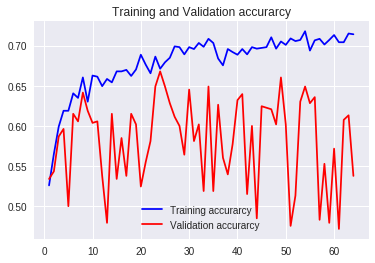

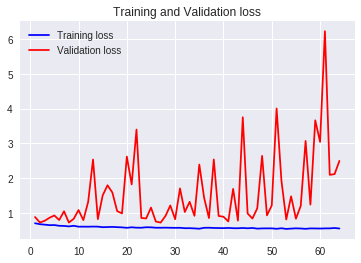

In [16]:
# plot the train and val curve
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

### Test Model

In [0]:
X_test, y_test = read_and_process_image(test_imgs)

X_test = np.array(X_test)
y_test = np.array(y_test)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow(X_test, y_test, batch_size=1)

ntest = len(X_test)

In [0]:
predict = model.predict_generator(test_generator, steps = ntest)

In [21]:
y_pred = predict > 0.5
y_true = y_test == 1

confusion_matrix(y_true, y_pred)

len(test_imgs)

report = metrics.classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.49      0.86      0.63      1325
        True       0.46      0.12      0.19      1325

   micro avg       0.49      0.49      0.49      2650
   macro avg       0.48      0.49      0.41      2650
weighted avg       0.48      0.49      0.41      2650



### Predict 10

In [0]:
X_test, y_test = read_and_process_image(test_imgs[0:10]) #Y_test in this case will be empty.
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

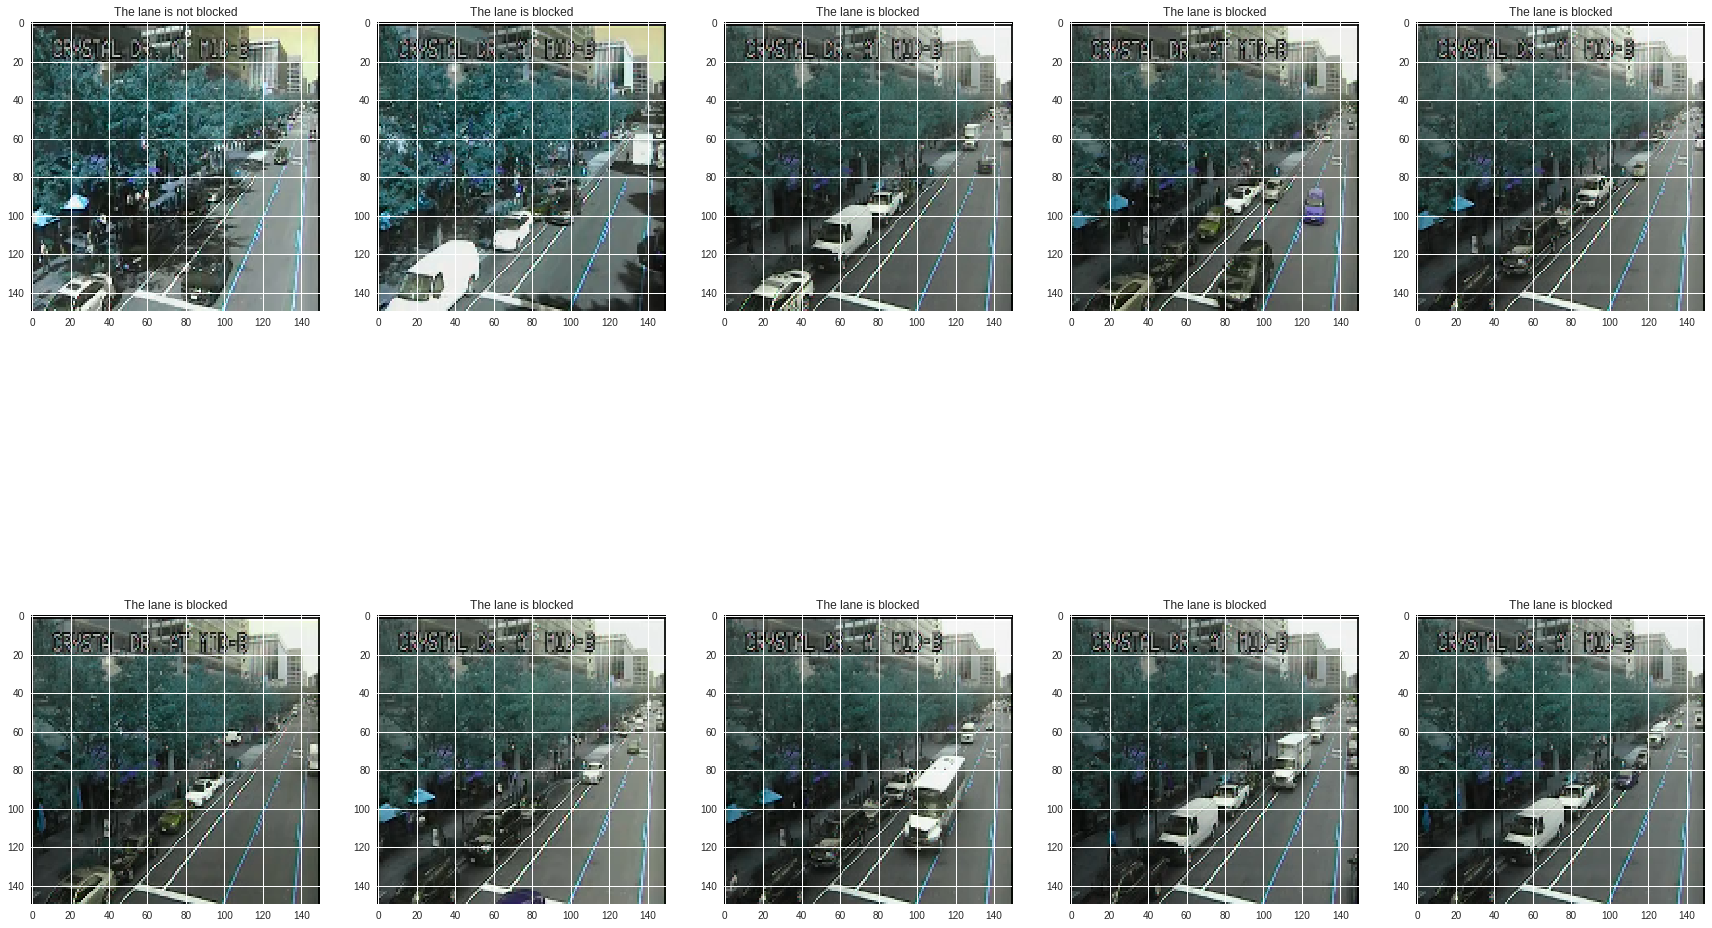

In [23]:
i = 0
text_labels = []
columns = 5
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    if pred > 0.5:
        text_labels.append('not blocked')
    else:
        text_labels.append('blocked')
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title('The lane is ' + text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()

### Load Saved Model Weights

In [0]:
# from google.colab import files
# model.save_weights('run_foo.h5')
# files.download('run_foo.h5')

In [0]:
# from google.colab import files
# files.upload()

In [0]:
# model.load_weights('run_foo.h5')

### Scratch Code

In [0]:
print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_val.shape)